In [1]:
import keras
import quandl
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K
from sklearn.model_selection import KFold

%matplotlib inline

Using TensorFlow backend.


In [24]:
#data = quandl.get('BCHARTS/BITFINEXUSD') -> OLD BUGGY DATASET (OBD)
data = quandl.get('BITFINEX/BTCUSD')

In [25]:
data.head()

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2014-04-15,513.9000,452.00,504.23500,505.0000,503.5000,504.97,21013.584774
2014-04-16,547.0000,495.00,537.50000,538.0000,537.0000,538.00,29633.358705
2014-04-17,538.5000,486.10,507.02000,508.0000,506.0400,508.00,20709.783819
2014-04-18,509.0000,474.25,483.77000,482.7500,482.7500,484.79,10458.045243
2014-04-19,513.9899,473.83,505.01065,507.4999,502.5313,507.49,8963.618369


In [27]:
print("data shape before embedding:",data.shape)

mean = data.mean(axis=0)
std = data.std(axis=0)

# zscore normalization
data = ( data - mean ) / std

# # of days past we want skynet to see
d = 15

X = np.zeros((data.shape[0],d,7))

# embedding d days in each DP (deslocamento)
for i in range(d,data.shape[0]):
    X[i,:,:] = data.iloc[i-d:i].values

#removing first d lines, this ones didn't have d days past
X = X[d:,:,:]

print("data shape after embedding:",X.shape)

data shape before embedding: (1336, 7)
data shape after embedding: (1321, 15, 7)


In [28]:
# creating labels
Y = data['Mid'] - data.shift(1)['Mid']

Y.shape

(1336,)

In [29]:
Y = Y > 0

#removing first line: second label refers to first DP ($$ delta)
Y = Y[1:]

#removing first d days because of the embedding
Y = Y[d:]

In [30]:
#removing last registry from X, since we had to remove first DP from Y
#specifying other dimensions for good practices - TY @lucasosouza
X = X[: -1,:,:]

In [31]:
# checking shapes
Y.shape, X.shape

((1320,), (1320, 15, 7))

In [32]:
# Adding channel layer, as expected by the convnet
X = X.reshape((Y.shape[0],d,7,1))
X.shape

(1320, 15, 7, 1)

In [33]:
# train / test split
#X_train = X[:-300,:,:,:]
#X_test = X[-300:,:,:,:]
#Y_train = Y[:-300]
#Y_test = Y[-300:]

# split the data 
kf = KFold(n_splits=8,shuffle=True,random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #print("TRAIN:", train_index, "TEST:", test_index)

In [35]:
def model(input_shape):
    
    X_input = Input(input_shape)
    
    #padding same so we dont lose size
    X = Conv2D(10,(3,3), strides=(1,1),name="conv0", padding="same")(X_input)
    X = BatchNormalization(axis=3,name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool0')(X)
    
    #Second conv
    X = Conv2D(30,(2,2), strides=(1,1),name="conv1", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool1')(X)
    
    #Third conv
    X = Conv2D(50,(1,1), strides=(1,1),name="conv2", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn2')(X)
    X = Activation('relu')(X)
    
    #fcs
    X = Flatten()(X)
    X = Dense(200,activation="relu")(X)
    X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(100,activation="relu")(X)
    X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(50,activation="relu")(X)
    X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(1,activation="sigmoid")(X)
    
    model = Model(inputs=X_input,outputs=X, name="model1")
    
    return model

In [36]:
#training the model, time for witchcraft
model = model(X[0].shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

model.fit(x = X_train, y = Y_train, epochs = 300, batch_size = 8,verbose=1)

Epoch 1/300
1155/1155 [==============================] - 1s 999us/step - loss: 0.7125 - acc: 0.5229
Epoch 2/300
1155/1155 [==============================] - 1s 729us/step - loss: 0.7082 - acc: 0.5065
Epoch 3/300
1155/1155 [==============================] - 1s 727us/step - loss: 0.7011 - acc: 0.4892
Epoch 4/300
1155/1155 [==============================] - 1s 734us/step - loss: 0.7018 - acc: 0.5281
Epoch 5/300
1155/1155 [==============================] - 1s 731us/step - loss: 0.6961 - acc: 0.5177
Epoch 6/300
1155/1155 [==============================] - 1s 848us/step - loss: 0.6957 - acc: 0.5420
Epoch 7/300
1155/1155 [==============================] - 1s 773us/step - loss: 0.6889 - acc: 0.5411
Epoch 8/300
1155/1155 [==============================] - 1s 771us/step - loss: 0.7014 - acc: 0.5013
Epoch 9/300
1155/1155 [==============================] - 1s 796us/step - loss: 0.6931 - acc: 0.5212
Epoch 10/300
1155/1155 [==============================] - 1s 751us/step - loss: 0.6925 - acc: 0.5316

1155/1155 [==============================] - 1s 1ms/step - loss: 0.3537 - acc: 0.8407
Epoch 83/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.3647 - acc: 0.8303
Epoch 84/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.3514 - acc: 0.8390
Epoch 85/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.3652 - acc: 0.8390
Epoch 86/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.3351 - acc: 0.8502
Epoch 87/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.3335 - acc: 0.8442
Epoch 88/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.3002 - acc: 0.8589
Epoch 89/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.3011 - acc: 0.8623
Epoch 90/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.2962 - acc: 0.8684
Epoch 91/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.2959 - acc: 0.8597
Epoch 92/300
1155/1155 

1155/1155 [==============================] - 1s 1ms/step - loss: 0.1354 - acc: 0.9420
Epoch 165/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1197 - acc: 0.9584A: 1s - l
Epoch 166/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1573 - acc: 0.9394
Epoch 167/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1190 - acc: 0.9524
Epoch 168/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1877 - acc: 0.9316
Epoch 169/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1443 - acc: 0.9498
Epoch 170/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1425 - acc: 0.9429
Epoch 171/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1404 - acc: 0.9463
Epoch 172/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1281 - acc: 0.9472
Epoch 173/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1211 - acc: 0.9498
Epoch

1155/1155 [==============================] - 1s 1ms/step - loss: 0.1024 - acc: 0.9619
Epoch 246/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1214 - acc: 0.9550
Epoch 247/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.0980 - acc: 0.9593
Epoch 248/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1363 - acc: 0.9541
Epoch 249/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.0859 - acc: 0.9680
Epoch 250/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.0672 - acc: 0.9706
Epoch 251/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.0669 - acc: 0.9758
Epoch 252/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.1020 - acc: 0.9654
Epoch 253/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.0777 - acc: 0.9714
Epoch 254/300
1155/1155 [==============================] - 1s 1ms/step - loss: 0.0901 - acc: 0.9645
Epoch 255/300


In [37]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print("Loss = " + str(preds[0]))
print("Acc = " + str(preds[1]))

165/165 [==============================] - 0s 828us/step

Loss = 2.69343784795
Acc = 0.509090909813


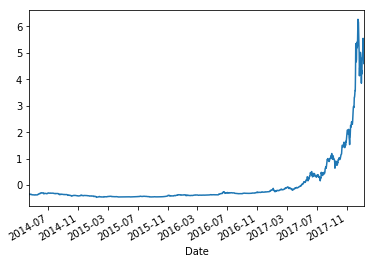

In [39]:
data['Mid'].plot()
